# LD3 oracle validation on random Erdos-Renyi graphs

## Preamble

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import platform
import time
import warnings
import networkx as nx
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import OrdinalEncoder
from dowhy import gcm
from dowhy.gcm.util.general import set_random_seed
from os import listdir
from os.path import isfile, join
from causallearn.utils.cit import CIT
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Custom scripts.
from data_generation import DataGeneration
from ld3 import LD3
#from effect_estimation import EstimationPipeline
from causal_discovery import utils
from causal_discovery.pc_alg import PCAlgorithm
from causal_discovery.ldecc import LDECCAlgorithm
from ldp import LDP
from ldp_utils import LDPUtils

# View versioning.
print("python version     :", platform.python_version())
print("numpy version      :", np.__version__)
print("pandas version     :", pd.__version__)
print("matplotlib version :", matplotlib.__version__)
print("seaborn version    :", sns.__version__)

python version     : 3.10.13
numpy version      : 1.26.3
pandas version     : 2.1.4
matplotlib version : 3.8.0
seaborn version    : 0.12.2


/Users/jmaasch/anaconda3/envs/icp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define functions

In [2]:
def plot_nx(adjacency_matrix,
            labels,
            figsize = (5,5),
            dpi = 50,
            node_size = 1500,
            arrow_size = 20):
    
    g = nx.from_numpy_array(adjacency_matrix, create_using = nx.DiGraph)
    plt.figure(figsize = figsize, dpi = dpi)  
    nx.draw_shell(g, 
                 node_size = node_size, 
                 labels = dict(zip(list(range(len(labels))), labels)), 
                 arrowsize = arrow_size,
                 node_color = "pink",
                 with_labels = True)
    plt.show()
    plt.close()

In [3]:
def get_ci(results: list,
           z: float = 1.96,
           return_mean: bool = True) -> tuple:

    '''
    Default is 95% confidence interval.
    '''

    mean = np.mean(results)
    se = stats.sem(results)
    ci = [mean - (z * se), mean + (z * se)]
    if return_mean:
        return mean, ci
    return ci

In [33]:
def get_exposure_outcome_parents(adj, verbose = False):

    '''
    Returns indices of a randomly selected exposure-outcome pair and the parents of outcome.
    Outcome is a leaf node with at least one parent.
    Exposure is one of its parents and is included in the parent set.

    For rows i and cols j, var i causes var j. Thus, if column j is sum zero then var j has no parents.
    If row i is sum zero, then var i has no children.
    '''

    # Identify leaves.
    column_sums = adj.sum(axis = 0)
    row_sums = adj.sum(axis = 1)
    leaf_idx = np.where((row_sums == 0) & (column_sums >= 1))[0]

    # Take random leaf as outcome.
    #y_idx = leaf_idx[np.random.choice(leaf_idx.shape[0], 1)]

    # Take leaf with most parents as outcome (argmax returns first occurrence).
    y_idx = leaf_idx[np.argmax(column_sums[leaf_idx])]

    # Find parents of outcome.
    parents_idx = np.where(adj[:,y_idx] == 1)[0]

    # Take random parent as exposure.
    x_idx = parents_idx[np.random.choice(parents_idx.shape[0], 1)][0]

    if verbose:
        print("leaf_idx", leaf_idx)
        print("y_idx", y_idx)
        print("x_idx", x_idx)
        print("parents_idx", parents_idx)
    
    return y_idx, x_idx, parents_idx

In [5]:
def eval_ld3_oracle(adjacency_matrices, exposures, outcomes, true_parents):
    total_times = []
    total_tests = []
    conditioning_set_sizes = []
    lengths = []
    accuracy_scores = []
    f1_scores = []
    precision_scores = []
    recall_scores = []
    ldputils = LDPUtils()
    for i in range(len(adjacency_matrices)):

        # Get ground truth.
        adj = adjacency_matrices[i]
        exposure = str(exposures[i])
        outcome = str(outcomes[i])
        true_acde = [str(x) for x in true_parents[i] if x != exposures[i]]
        plot_nx(adj, labels = range(adj.shape[1]))

        # Run LD3.
        start = time.time()
        ld3 = LD3(independence_test = "oracle")
        ld3.dag = adj
        ld3.var_names = [str(x) for x in list(range(ld3.dag.shape[1]))]
        sdc,acde = ld3.get_sdc_cde_adjustment(exposure = exposure, 
                                              outcome = outcome)
        total_time = time.time() - start
        print("\nComplete in {} s.".format(round(total_time, 3)))
        print("Total independence tests performed:", ld3.total_tests)
        print("Conditioning set sizes:", ld3.conditioning_set_sizes)

        # Evaluate structural direct criterion.
        print("SDC =", sdc)
        if not sdc:
            print("No direct discrimination detected.")
        else:
            print("Direct discrimination detected.")
        print("Exposure   =", exposure)
        print("Outcome    =", outcome)
        print("Pred A_CDE =", acde)
        print("True A_CDE =", true_acde)

        # Log results.
        total_times.append(total_time)
        total_tests.append(ld3.total_tests)
        conditioning_set_sizes.append(ld3.conditioning_set_sizes)
        lengths.append(len(acde))
        if len(true_acde) == 0 and len(acde) == 0:
            bool_true = [0,1]
            bool_pred = [0,1]
        else:
            bool_true = [1 if x in true_acde else 0 for x in ld3.var_names]
            bool_pred = [1 if x in acde else 0 for x in ld3.var_names]
        accuracy = accuracy_score(bool_true, bool_pred)
        accuracy_scores.append(accuracy)
        f1 = f1_score(bool_true, bool_pred)
        f1_scores.append(f1)
        precision = precision_score(bool_true, bool_pred)
        precision_scores.append(precision)
        recall = recall_score(bool_true, bool_pred)
        recall_scores.append(recall)

    # Print evaluation metrics.
    mean, ci = ldputils.get_ci(total_times)
    print("\nMean time       = {} [{},{}]".format(round(mean,3), round(ci[0],3), round(ci[1],3)))
    mean, ci = ldputils.get_ci(total_tests)
    print("Mean tests      = {} [{},{}]".format(round(mean,2), round(ci[0],2), round(ci[1],2)))
    mean, ci = ldputils.get_ci(lengths)
    print("Mean len        = {} [{},{}]".format(round(mean,2), round(ci[0],2), round(ci[1],2)))
    mean, ci = ldputils.get_ci(accuracy_scores)
    print("Mean accuracy   = {} [{},{}]".format(round(mean,2), round(ci[0],2), round(ci[1],2)))
    mean, ci = ldputils.get_ci(f1_scores)
    print("Mean F1         = {} [{},{}]".format(round(mean,2), round(ci[0],2), round(ci[1],2)))
    mean, ci = ldputils.get_ci(precision_scores)
    print("Mean precision  = {} [{},{}]".format(round(mean,2), round(ci[0],2), round(ci[1],2)))
    mean, ci = ldputils.get_ci(recall_scores)
    print("Mean recall     = {} [{},{}]".format(round(mean,2), round(ci[0],2), round(ci[1],2)))

## Read data

In [6]:
# Erdos-Renyi graphs.
df_5n_5m = pd.read_csv("data/erdos_renyi/erdos_renyi_5n_5m.csv")
df_10n_10m = pd.read_csv("data/erdos_renyi/erdos_renyi_10n_10m.csv")
df_20n_20m = pd.read_csv("data/erdos_renyi/erdos_renyi_20n_20m.csv")
df_30n_30m = pd.read_csv("data/erdos_renyi/erdos_renyi_30n_30m.csv")
df_40n_40m = pd.read_csv("data/erdos_renyi/erdos_renyi_40n_40m.csv")
df_50n_50m = pd.read_csv("data/erdos_renyi/erdos_renyi_50n_50m.csv")
df_100n_150m = pd.read_csv("data/erdos_renyi/erdos_renyi_100n_150m.csv")
df_200n_300m = pd.read_csv("data/erdos_renyi/erdos_renyi_200n_300m.csv")
df_500n_700m = pd.read_csv("data/erdos_renyi/erdos_renyi_500n_700m.csv")

In [7]:
display(df_5n_5m.head(5))

X1  X2  X3  X4  X5  Replicate
0   0   1   0   1   1          1
1   0   0   0   1   0          1
2   0   0   0   0   0          1
3   0   0   0   0   1          1
4   0   0   0   0   0          1

In [8]:
display(df_10n_10m.head(10))

X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  Replicate
0   0   0   0   0   1   0   1   1   0    0          1
1   0   0   0   0   1   0   0   0   0    0          1
2   0   0   0   1   1   0   1   0   0    0          1
3   0   0   0   0   0   0   0   0   0    0          1
4   0   0   0   0   0   0   0   0   0    0          1
5   0   0   0   0   0   0   0   1   0    0          1
6   0   0   0   0   0   0   0   0   1    0          1
7   0   0   0   0   0   0   0   0   1    0          1
8   0   0   0   0   0   0   0   0   0    0          1
9   0   0   0   0   0   0   0   0   0    0          1

In [9]:
display(df_20n_20m.head(20))

X1  X2  X3  X4  X5  X6  X7  X8  X9  X10  ...  X12  X13  X14  X15  X16  \
0    0   0   0   0   0   0   0   0   0    0  ...    0    0    0    0    1   
1    0   0   0   0   0   0   0   0   1    0  ...    0    1    0    0    0   
2    0   0   0   0   0   1   0   0   0    0  ...    0    0    0    0    0   
3    0   0   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   
4    0   0   0   0   0   0   0   0   0    0  ...    0    0    0    1    0   
5    0   0   0   0   0   0   0   0   0    0  ...    0    1    0    0    0   
6    0   0   0   0   0   0   0   0   0    1  ...    0    0    0    0    0   
7    0   0   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   
8    0   0   0   0   0   0   0   0   0    0  ...    0    0    0    1    1   
9    0   0   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   
10   0   0   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   
11   0   0   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   
12   0   0   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   
13   0   0   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   
14   0   0   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   
15   0   0   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   
16   0   0   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   
17   0   0   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   
18   0   0   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   
19   0   0   0   0   0   0   0   0   0    0  ...    0    0    0    0    0   

    X17  X18  X19  X20  Replicate  
0     0    1    0    0          1  
1     0    1    0    0          1  
2     0    0    0    0          1  
3     0    1    1    0          1  
4     0    0    0    0          1  
5     0    0    0    0          1  
6     1    0    0    0          1  
7     0    0    0    0          1  
8     0    0    0    0          1  
9     0    0    0    0          1  
10    0    0    0    1          1  
11    0    0    0    0          1  
12    0    0    0    0          1  
13    0    0    0    0          1  
14    0    0    0    0          1  
15    1    0    0    0          1  
16    0    0    0    0          1  
17    0    0    0    0          1  
18    0    0    0    0          1  
19    0    0    0    0          1  

[20 rows x 21 columns]

In [10]:
# Extract adjacency matrices.
n = 5
df_5n_5m = df_5n_5m.drop(columns = "Replicate")
adj_matrices_5n_5m = [df_5n_5m[i:i+n].to_numpy() for i in range(0,df_5n_5m.shape[0],n)]

n = 10
df_10n_10m = df_10n_10m.drop(columns = "Replicate")
adj_matrices_10n_10m = [df_10n_10m[i:i+n].to_numpy() for i in range(0,df_10n_10m.shape[0],n)]

# Extract adjacency matrices.
n = 20
df_20n_20m = df_20n_20m.drop(columns = "Replicate")
adj_matrices_20n_20m = [df_20n_20m[i:i+n].to_numpy() for i in range(0,df_20n_20m.shape[0],n)]

# Extract adjacency matrices.
n = 30
df_30n_30m = df_30n_30m.drop(columns = "Replicate")
adj_matrices_30n_30m = [df_30n_30m[i:i+n].to_numpy() for i in range(0,df_30n_30m.shape[0],n)]

# Extract adjacency matrices.
n = 40
df_40n_40m = df_40n_40m.drop(columns = "Replicate")
adj_matrices_40n_40m = [df_40n_40m[i:i+n].to_numpy() for i in range(0,df_40n_40m.shape[0],n)]

# Extract adjacency matrices.
n = 50
df_50n_50m = df_50n_50m.drop(columns = "Replicate")
adj_matrices_50n_50m = [df_50n_50m[i:i+n].to_numpy() for i in range(0,df_50n_50m.shape[0],n)]

# Extract adjacency matrices.
n = 100
df_100n_150m = df_100n_150m.drop(columns = "Replicate")
adj_matrices_100n_150m = [df_100n_150m[i:i+n].to_numpy() for i in range(0,df_100n_150m.shape[0],n)]

In [28]:
# Extract adjacency matrices.
n = 200
df_200n_300m = df_200n_300m.drop(columns = "Replicate")
adj_matrices_200n_300m = [df_200n_300m[i:i+n].to_numpy() for i in range(0,df_200n_300m.shape[0],n)]

In [37]:
# Extract adjacency matrices.
n = 500
df_500n_700m = df_500n_700m.drop(columns = "Replicate")
adj_matrices_500n_700m = [df_500n_700m[i:i+n].to_numpy() for i in range(0,df_500n_700m.shape[0],n)]

## Get exposure-outcome pairs

array([[0, 1, 0, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

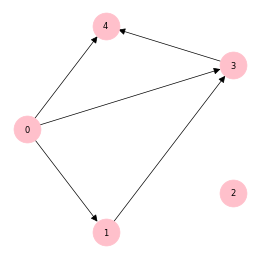

column_sums[leaf_idx]: [2]
y_idx: 4
leaf_idx [4]
y_idx 4
x_idx 0
parents_idx [0 3]


array([[0, 0, 1, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

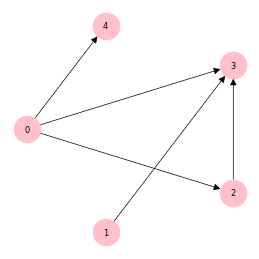

column_sums[leaf_idx]: [3 1]
y_idx: 3
leaf_idx [3 4]
y_idx 3
x_idx 1
parents_idx [0 1 2]


array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

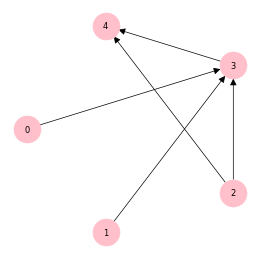

column_sums[leaf_idx]: [2]
y_idx: 4
leaf_idx [4]
y_idx 4
x_idx 3
parents_idx [2 3]


array([[0, 1, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

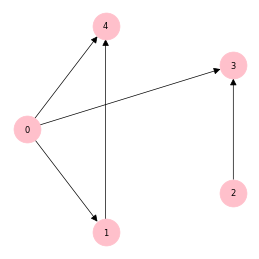

column_sums[leaf_idx]: [2 2]
y_idx: 3
leaf_idx [3 4]
y_idx 3
x_idx 0
parents_idx [0 2]


array([[0, 1, 0, 0, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

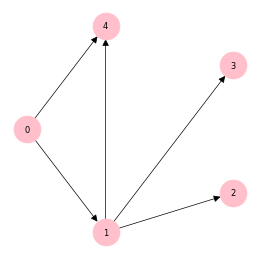

column_sums[leaf_idx]: [1 1 2]
y_idx: 4
leaf_idx [2 3 4]
y_idx 4
x_idx 0
parents_idx [0 1]


array([[0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

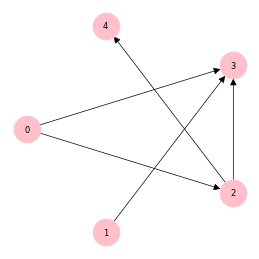

column_sums[leaf_idx]: [3 1]
y_idx: 3
leaf_idx [3 4]
y_idx 3
x_idx 2
parents_idx [0 1 2]


array([[0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

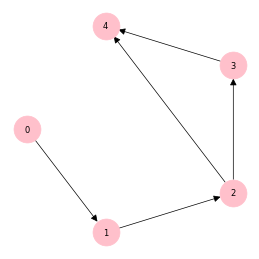

column_sums[leaf_idx]: [2]
y_idx: 4
leaf_idx [4]
y_idx 4
x_idx 3
parents_idx [2 3]


array([[0, 1, 0, 1, 0],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

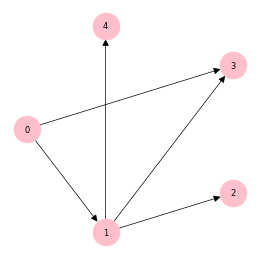

column_sums[leaf_idx]: [1 2 1]
y_idx: 3
leaf_idx [2 3 4]
y_idx 3
x_idx 0
parents_idx [0 1]


array([[0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

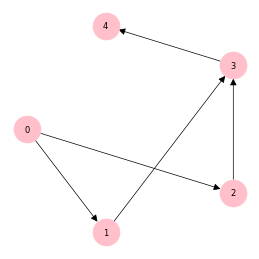

column_sums[leaf_idx]: [1]
y_idx: 4
leaf_idx [4]
y_idx 4
x_idx 3
parents_idx [3]


array([[0, 1, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0]])

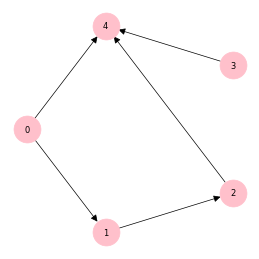

column_sums[leaf_idx]: [3]
y_idx: 4
leaf_idx [4]
y_idx 4
x_idx 3
parents_idx [0 2 3]


In [11]:
outcomes_5n_5m = []
exposures_5n_5m = []
true_parents_5n_5m = []
for adj in adj_matrices_5n_5m:
    display(adj)
    plot_nx(adj, labels = range(adj.shape[1]))
    y_idx, x_idx, parents_idx = get_exposure_outcome_parents(adj, verbose = True)
    outcomes_5n_5m.append(y_idx)
    exposures_5n_5m.append(x_idx)
    true_parents_5n_5m.append([i for i in parents_idx if i != x_idx])

array([[0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

column_sums[leaf_idx]: [1 3 2]
y_idx: 4
leaf_idx [3 4 8]
y_idx 4
x_idx 2
parents_idx [0 1 2]


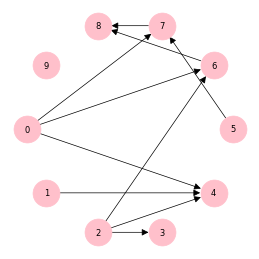

array([[0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

column_sums[leaf_idx]: [1 2 2]
y_idx: 8
leaf_idx [2 8 9]
y_idx 8
x_idx 0
parents_idx [0 7]


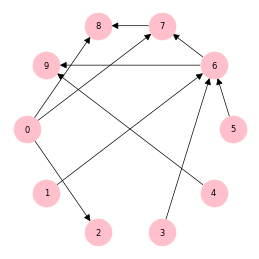

array([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

column_sums[leaf_idx]: [2 1 1]
y_idx: 5
leaf_idx [5 8 9]
y_idx 5
x_idx 3
parents_idx [2 3]


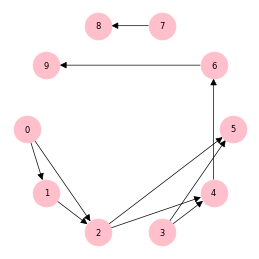

array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

column_sums[leaf_idx]: [1 2 2 1]
y_idx: 7
leaf_idx [2 7 8 9]
y_idx 7
x_idx 4
parents_idx [4 6]


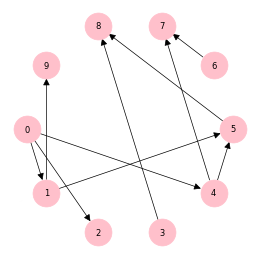

array([[0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

column_sums[leaf_idx]: [1 1 2 4]
y_idx: 8
leaf_idx [2 5 7 8]
y_idx 8
x_idx 4
parents_idx [0 3 4 6]


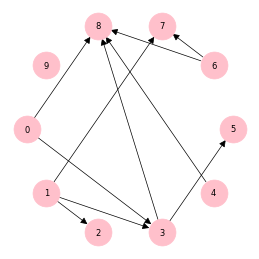

array([[0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

column_sums[leaf_idx]: [2 1 1]
y_idx: 6
leaf_idx [6 8 9]
y_idx 6
x_idx 1
parents_idx [1 4]


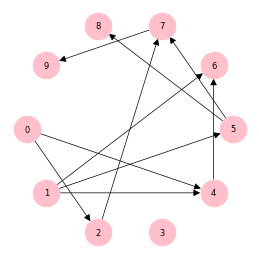

array([[0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

column_sums[leaf_idx]: [2 1 1 1 2]
y_idx: 4
leaf_idx [4 5 6 8 9]
y_idx 4
x_idx 1
parents_idx [0 1]


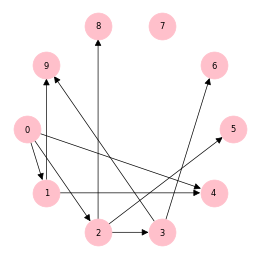

array([[0, 1, 0, 0, 1, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

column_sums[leaf_idx]: [2 1 1 1]
y_idx: 5
leaf_idx [5 7 8 9]
y_idx 5
x_idx 3
parents_idx [0 3]


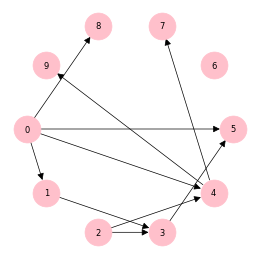

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

column_sums[leaf_idx]: [1 5 1]
y_idx: 8
leaf_idx [7 8 9]
y_idx 8
x_idx 6
parents_idx [0 1 2 3 6]


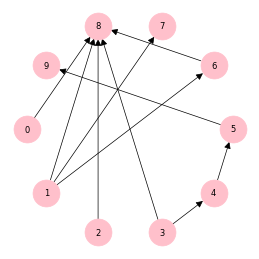

array([[0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

column_sums[leaf_idx]: [1]
y_idx: 9
leaf_idx [9]
y_idx 9
x_idx 8
parents_idx [8]


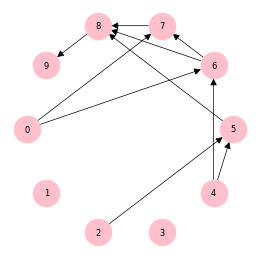

In [12]:
outcomes_10n_10m = []
exposures_10n_10m = []
true_parents_10n_10m = []
for adj in adj_matrices_10n_10m:
    display(adj)
    y_idx, x_idx, parents_idx = get_exposure_outcome_parents(adj, verbose = True)
    outcomes_10n_10m.append(y_idx)
    exposures_10n_10m.append(x_idx)
    true_parents_10n_10m.append([i for i in parents_idx if i != x_idx])
    plot_nx(adj, labels = range(adj.shape[1]))

In [13]:
outcomes_20n_20m = []
exposures_20n_20m = []
true_parents_20n_20m = []
for adj in adj_matrices_20n_20m:
    #display(adj)
    y_idx, x_idx, parents_idx = get_exposure_outcome_parents(adj, verbose = True)
    outcomes_20n_20m.append(y_idx)
    exposures_20n_20m.append(x_idx)
    true_parents_20n_20m.append([i for i in parents_idx if i != x_idx])
    #plot_nx(adj, labels = range(adj.shape[1]))

column_sums[leaf_idx]: [1 2 2 2 3 1 1]
y_idx: 17
leaf_idx [ 9 12 14 16 17 18 19]
y_idx 17
x_idx 1
parents_idx [0 1 3]
column_sums[leaf_idx]: [2 1 1 1 2 3 1]
y_idx: 18
leaf_idx [ 9 10 13 14 16 18 19]
y_idx 18
x_idx 3
parents_idx [ 3  7 17]
column_sums[leaf_idx]: [4 1 1 2 1]
y_idx: 11
leaf_idx [11 13 15 17 18]
y_idx 11
x_idx 1
parents_idx [1 2 5 8]
column_sums[leaf_idx]: [2 1 3 2]
y_idx: 18
leaf_idx [10 13 18 19]
y_idx 18
x_idx 15
parents_idx [ 4 15 16]
column_sums[leaf_idx]: [1 2 1 2 1 3 1 1 3]
y_idx: 15
leaf_idx [ 1  6  7 13 14 15 17 18 19]
y_idx 15
x_idx 3
parents_idx [3 4 9]
column_sums[leaf_idx]: [2 1 3 1 1 1 1]
y_idx: 12
leaf_idx [ 7 11 12 13 17 18 19]
y_idx 12
x_idx 6
parents_idx [ 5  6 10]
column_sums[leaf_idx]: [1 2 1 2 1 1 1 3 3]
y_idx: 18
leaf_idx [11 12 13 14 15 16 17 18 19]
y_idx 18
x_idx 9
parents_idx [2 4 9]
column_sums[leaf_idx]: [1 1 1 6 2 3]
y_idx: 17
leaf_idx [ 1 10 14 17 18 19]
y_idx 17
x_idx 12
parents_idx [ 0  5  9 12 13 16]
column_sums[leaf_idx]: [1 2 5 3]
y_idx: 1

In [14]:
outcomes_30n_30m = []
exposures_30n_30m = []
true_parents_30n_30m = []
for adj in adj_matrices_30n_30m:
    y_idx, x_idx, parents_idx = get_exposure_outcome_parents(adj, verbose = True)
    outcomes_30n_30m.append(y_idx)
    exposures_30n_30m.append(x_idx)
    true_parents_30n_30m.append([i for i in parents_idx if i != x_idx])

column_sums[leaf_idx]: [1 2 2 1 2 1 3 2 2 3]
y_idx: 24
leaf_idx [ 9 13 14 18 21 22 24 26 27 29]
y_idx 24
x_idx 12
parents_idx [ 1  5 12]
column_sums[leaf_idx]: [1 1 3 2 2 2 1 3 3 1 2]
y_idx: 13
leaf_idx [ 6 12 13 16 19 21 24 25 26 27 29]
y_idx 13
x_idx 10
parents_idx [ 5 10 11]
column_sums[leaf_idx]: [1 2 1 1 1 1 7]
y_idx: 29
leaf_idx [ 4 12 18 23 24 28 29]
y_idx 29
x_idx 14
parents_idx [11 14 15 21 22 25 27]
column_sums[leaf_idx]: [1 1 1 2 2 5 2 1 1]
y_idx: 25
leaf_idx [14 15 17 20 23 25 26 28 29]
y_idx 25
x_idx 0
parents_idx [ 0 10 11 12 24]
column_sums[leaf_idx]: [1 1 2 2 2 1 1 4 2]
y_idx: 28
leaf_idx [18 19 21 23 24 26 27 28 29]
y_idx 28
x_idx 10
parents_idx [10 14 15 16]
column_sums[leaf_idx]: [1 4 3 2 5 1 1]
y_idx: 27
leaf_idx [13 20 24 26 27 28 29]
y_idx 27
x_idx 1
parents_idx [ 0  1 11 14 25]
column_sums[leaf_idx]: [1 1 1 3 1 1 2 2 2 1 1 2]
y_idx: 21
leaf_idx [ 2  5 15 21 22 23 24 25 26 27 28 29]
y_idx 21
x_idx 12
parents_idx [ 7 12 19]
column_sums[leaf_idx]: [1 1 5 2 1 3 2 1 2

In [15]:
outcomes_40n_40m = []
exposures_40n_40m = []
true_parents_40n_40m = []
for adj in adj_matrices_40n_40m:
    y_idx, x_idx, parents_idx = get_exposure_outcome_parents(adj, verbose = True)
    outcomes_40n_40m.append(y_idx)
    exposures_40n_40m.append(x_idx)
    true_parents_40n_40m.append([i for i in parents_idx if i != x_idx])

column_sums[leaf_idx]: [3 2 1 2 3 1 4 1 2 1 2 1 1]
y_idx: 33
leaf_idx [16 23 25 27 29 31 33 34 35 36 37 38 39]
y_idx 33
x_idx 7
parents_idx [ 7 11 28 32]
column_sums[leaf_idx]: [2 1 1 3 2 1 1 4 2]
y_idx: 38
leaf_idx [ 4 27 29 31 33 35 36 38 39]
y_idx 38
x_idx 15
parents_idx [ 2 15 26 34]
column_sums[leaf_idx]: [1 2 1 3 1 1 3 4 1 2 4]
y_idx: 33
leaf_idx [18 20 23 26 30 31 32 33 36 37 39]
y_idx 33
x_idx 16
parents_idx [16 22 24 28]
column_sums[leaf_idx]: [2 1 1 2 1 2 1 4 2 1 1 1 2 5]
y_idx: 39
leaf_idx [ 5  7 11 21 23 27 32 33 34 35 36 37 38 39]
y_idx 39
x_idx 10
parents_idx [ 3 10 16 19 22]
column_sums[leaf_idx]: [1 2 2 1 1 1 1 4 6]
y_idx: 39
leaf_idx [ 2 10 14 25 27 29 34 37 39]
y_idx 39
x_idx 32
parents_idx [ 6 17 18 20 23 32]
column_sums[leaf_idx]: [1 1 3 3 1 3 1 2 1 2 1 1 1 2]
y_idx: 22
leaf_idx [12 15 22 24 27 29 30 31 32 33 36 37 38 39]
y_idx 22
x_idx 11
parents_idx [ 2  9 11]
column_sums[leaf_idx]: [3 1 2 1 1 3 4 2 1 3]
y_idx: 35
leaf_idx [10 23 25 27 33 34 35 36 37 39]
y_idx 35


In [16]:
outcomes_50n_50m = []
exposures_50n_50m = []
true_parents_50n_50m = []
for adj in adj_matrices_50n_50m:
    y_idx, x_idx, parents_idx = get_exposure_outcome_parents(adj, verbose = True)
    outcomes_50n_50m.append(y_idx)
    exposures_50n_50m.append(x_idx)
    true_parents_50n_50m.append([i for i in parents_idx if i != x_idx])

column_sums[leaf_idx]: [1 3 2 1 1 2 1 2 2 1 2 2 1 4 1 2 3 1 1]
y_idx: 44
leaf_idx [19 22 23 26 28 29 30 33 36 39 41 42 43 44 45 46 47 48 49]
y_idx 44
x_idx 40
parents_idx [ 2 20 32 40]
column_sums[leaf_idx]: [2 2 2 1 1 2 1 4 3 1 2 2 1 2]
y_idx: 41
leaf_idx [12 18 22 25 32 36 37 41 42 44 45 47 48 49]
y_idx 41
x_idx 15
parents_idx [ 3 13 15 26]
column_sums[leaf_idx]: [1 1 1 1 1 2 2 1 3 3 2 2 1 1 4 2 2 2]
y_idx: 44
leaf_idx [12 16 24 26 27 29 31 32 37 38 40 41 42 43 44 46 48 49]
y_idx 44
x_idx 3
parents_idx [ 3 20 23 36]
column_sums[leaf_idx]: [2 1 1 3 2 2 3 3 2 6 1 2 3]
y_idx: 44
leaf_idx [19 20 26 30 31 38 40 41 43 44 45 46 48]
y_idx 44
x_idx 39
parents_idx [10 11 14 29 36 39]
column_sums[leaf_idx]: [1 2 1 1 1 3 1 1 1 1 2 1 3 6 1 1 2 4]
y_idx: 43
leaf_idx [11 18 21 24 28 29 31 33 35 38 39 40 41 43 44 46 48 49]
y_idx 43
x_idx 17
parents_idx [ 3  8 10 17 23 42]
column_sums[leaf_idx]: [1 2 1 3 1 2 1 2 2 1 1 1 3 3 2 2 3 1]
y_idx: 26
leaf_idx [ 5 22 24 26 30 33 34 36 37 38 39 41 42 44 45 46 

In [17]:
outcomes_100n_150m = []
exposures_100n_150m = []
true_parents_100n_150m = []
for adj in adj_matrices_100n_150m:
    y_idx, x_idx, parents_idx = get_exposure_outcome_parents(adj, verbose = False)
    outcomes_100n_150m.append(y_idx)
    exposures_100n_150m.append(x_idx)
    true_parents_100n_150m.append([i for i in parents_idx if i != x_idx])

column_sums[leaf_idx]: [2 2 2 2 5 2 1 4 4 3 5 3 2 3 3 2 3 2 2 3 2 2 3 3 1 2 2]
y_idx: 57
column_sums[leaf_idx]: [1 1 1 2 2 2 3 1 1 3 3 4 2 2 5 1 2 4 3 4 3 7 4]
y_idx: 98
column_sums[leaf_idx]: [1 3 1 1 3 2 2 2 1 3 3 2 3 2 3 2 5 5 3 2 1 3 2 4 6 2 6 1]
y_idx: 95
column_sums[leaf_idx]: [1 2 1 2 1 2 1 3 2 1 1 4 3 2 5 1 2 3 1 3 4 1 2 3 3 1 1 1 4 2]
y_idx: 80
column_sums[leaf_idx]: [1 1 2 3 3 3 3 3 1 4 2 1 4 3 2 4 1 6 2 4 4 1]
y_idx: 95
column_sums[leaf_idx]: [1 1 1 2 1 4 3 2 2 1 1 3 2 4 2 1 4 3 3 3 1 1 5 3 2 4 3 5 2]
y_idx: 92
column_sums[leaf_idx]: [3 1 3 3 3 1 5 4 3 3 1 1 3 1 3 4 1 4 2 2 3 2 2 6 3 3 2 3 1 3 1 1 1 3]
y_idx: 89
column_sums[leaf_idx]: [1 4 2 1 1 3 2 5 3 5 1 5 3 6 3 2 3 4 7 5 1 1 3 3]
y_idx: 94
column_sums[leaf_idx]: [4 2 2 1 1 1 1 2 2 2 2 1 2 2 2 5 3 2 6 2 5 5 2 6 1 3]
y_idx: 90
column_sums[leaf_idx]: [1 1 2 1 1 1 3 1 2 3 2 4 3 2 2 1 2 4 1 1 3 4 4 4 4 1 5 8]
y_idx: 99


In [34]:
outcomes_200n_300m = []
exposures_200n_300m = []
true_parents_200n_300m = []
for adj in adj_matrices_200n_300m:
    y_idx, x_idx, parents_idx = get_exposure_outcome_parents(adj, verbose = False)
    outcomes_200n_300m.append(y_idx)
    exposures_200n_300m.append(x_idx)
    true_parents_200n_300m.append([i for i in parents_idx if i != x_idx])

In [38]:
outcomes_500n_700m = []
exposures_500n_700m = []
true_parents_500n_700m = []
for adj in adj_matrices_500n_700m:
    y_idx, x_idx, parents_idx = get_exposure_outcome_parents(adj, verbose = False)
    outcomes_500n_700m.append(y_idx)
    exposures_500n_700m.append(x_idx)
    true_parents_500n_700m.append([i for i in parents_idx if i != x_idx])

## LD3

### 5 nodes

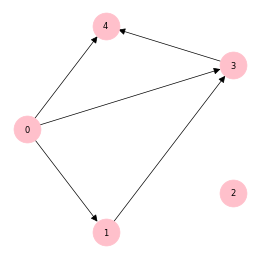


Complete in 0.001 s.
Total independence tests performed: 13
Conditioning set sizes: [3, 3]
SDC = 1
Direct discrimination detected.
Exposure   = 0
Outcome    = 4
Pred A_CDE = ['3']
True A_CDE = ['3']


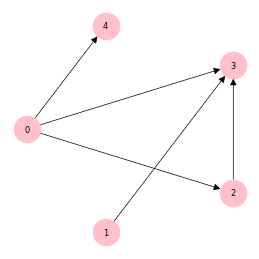


Complete in 0.001 s.
Total independence tests performed: 16
Conditioning set sizes: [3, 3, 3]
SDC = 1
Direct discrimination detected.
Exposure   = 1
Outcome    = 3
Pred A_CDE = ['0', '2']
True A_CDE = ['0', '2']


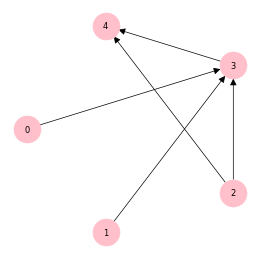


Complete in 0.001 s.
Total independence tests performed: 16
Conditioning set sizes: [4, 4, 4]
SDC = 1
Direct discrimination detected.
Exposure   = 3
Outcome    = 4
Pred A_CDE = ['2']
True A_CDE = ['2']


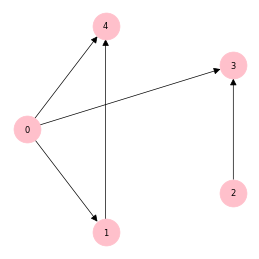


Complete in 0.002 s.
Total independence tests performed: 12
Conditioning set sizes: [1]
SDC = 1
Direct discrimination detected.
Exposure   = 0
Outcome    = 3
Pred A_CDE = ['2']
True A_CDE = ['2']


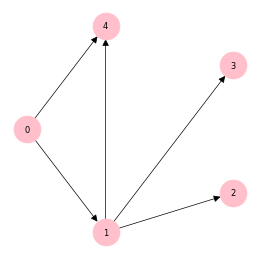


Complete in 0.001 s.
Total independence tests performed: 16
Conditioning set sizes: [4, 4, 4]
SDC = 1
Direct discrimination detected.
Exposure   = 0
Outcome    = 4
Pred A_CDE = ['1']
True A_CDE = ['1']


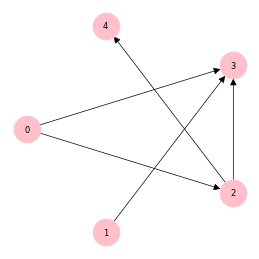


Complete in 0.001 s.
Total independence tests performed: 14
Conditioning set sizes: [3, 2]
SDC = 1
Direct discrimination detected.
Exposure   = 2
Outcome    = 3
Pred A_CDE = ['0', '1']
True A_CDE = ['0', '1']


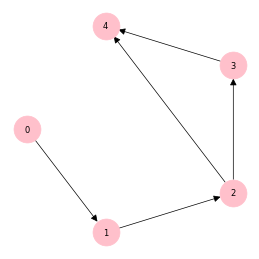


Complete in 0.001 s.
Total independence tests performed: 16
Conditioning set sizes: [4, 4, 4]
SDC = 1
Direct discrimination detected.
Exposure   = 3
Outcome    = 4
Pred A_CDE = ['2']
True A_CDE = ['2']


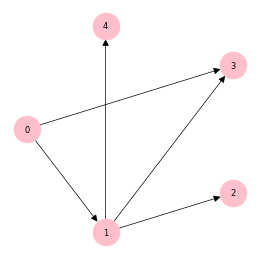


Complete in 0.001 s.
Total independence tests performed: 16
Conditioning set sizes: [4, 4, 4]
SDC = 1
Direct discrimination detected.
Exposure   = 0
Outcome    = 3
Pred A_CDE = ['1']
True A_CDE = ['1']


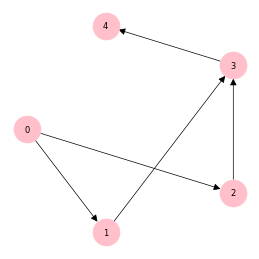


Complete in 0.001 s.
Total independence tests performed: 10
Conditioning set sizes: []
SDC = 1
Direct discrimination detected.
Exposure   = 3
Outcome    = 4
Pred A_CDE = []
True A_CDE = []


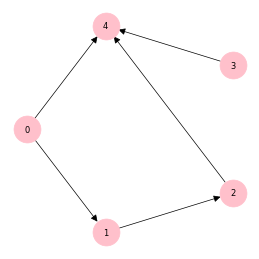


Complete in 0.001 s.
Total independence tests performed: 16
Conditioning set sizes: [3, 3, 3]
SDC = 1
Direct discrimination detected.
Exposure   = 3
Outcome    = 4
Pred A_CDE = ['0', '2']
True A_CDE = ['0', '2']

Mean time       = 0.001 [0.001,0.001]
Mean tests      = 14.5 [13.15,15.85]
Mean len        = 1.2 [0.81,1.59]
Mean accuracy   = 1.0 [1.0,1.0]
Mean F1         = 1.0 [1.0,1.0]
Mean precision  = 1.0 [1.0,1.0]
Mean recall     = 1.0 [1.0,1.0]


In [18]:
# Evaluate 5x5 matrices.
eval_ld3_oracle(adj_matrices_5n_5m, exposures_5n_5m, outcomes_5n_5m, true_parents_5n_5m)

### 10 nodes

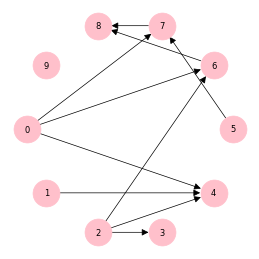


Complete in 0.003 s.
Total independence tests performed: 33
Conditioning set sizes: [6, 6, 3, 3, 3]
SDC = 1
Direct discrimination detected.
Exposure   = 2
Outcome    = 4
Pred A_CDE = ['0', '1']
True A_CDE = ['0', '1']


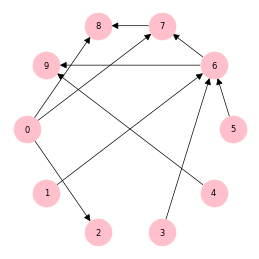


Complete in 0.004 s.
Total independence tests performed: 36
Conditioning set sizes: [7, 6, 6, 6, 6, 6]
SDC = 1
Direct discrimination detected.
Exposure   = 0
Outcome    = 8
Pred A_CDE = ['7']
True A_CDE = ['7']


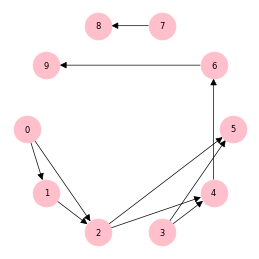


Complete in 0.003 s.
Total independence tests performed: 35
Conditioning set sizes: [7, 7, 7, 3, 3, 3]
SDC = 1
Direct discrimination detected.
Exposure   = 3
Outcome    = 5
Pred A_CDE = ['2']
True A_CDE = ['2']


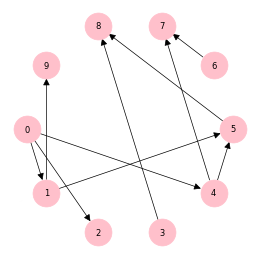


Complete in 0.002 s.
Total independence tests performed: 26
Conditioning set sizes: [1]
SDC = 1
Direct discrimination detected.
Exposure   = 4
Outcome    = 7
Pred A_CDE = ['6']
True A_CDE = ['6']


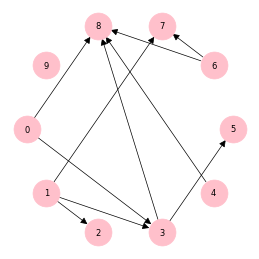


Complete in 0.003 s.
Total independence tests performed: 38
Conditioning set sizes: [7, 7, 7, 7, 7, 7, 7]
SDC = 1
Direct discrimination detected.
Exposure   = 4
Outcome    = 8
Pred A_CDE = ['0', '3', '6']
True A_CDE = ['0', '3', '6']


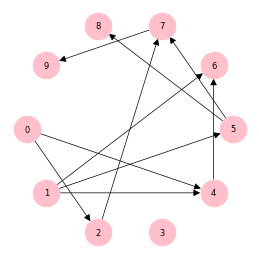


Complete in 0.003 s.
Total independence tests performed: 34
Conditioning set sizes: [6, 6, 6, 3, 3]
SDC = 1
Direct discrimination detected.
Exposure   = 1
Outcome    = 6
Pred A_CDE = ['4']
True A_CDE = ['4']


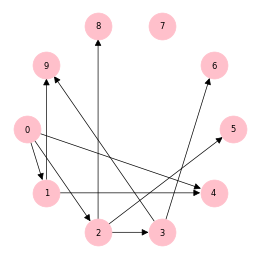


Complete in 0.003 s.
Total independence tests performed: 38
Conditioning set sizes: [8, 8, 8, 8, 8, 8, 8]
SDC = 1
Direct discrimination detected.
Exposure   = 1
Outcome    = 4
Pred A_CDE = ['0']
True A_CDE = ['0']


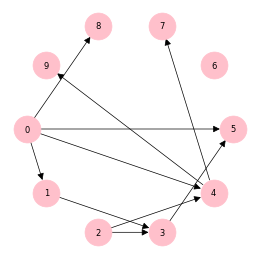


Complete in 0.003 s.
Total independence tests performed: 38
Conditioning set sizes: [8, 8, 8, 8, 8, 8, 8]
SDC = 1
Direct discrimination detected.
Exposure   = 3
Outcome    = 5
Pred A_CDE = ['0']
True A_CDE = ['0']


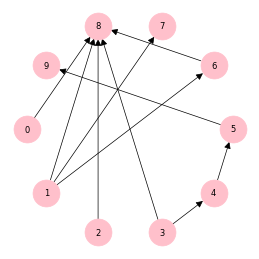


Complete in 0.003 s.
Total independence tests performed: 41
Conditioning set sizes: [9, 9, 7, 7, 7, 7, 7, 7]
SDC = 1
Direct discrimination detected.
Exposure   = 6
Outcome    = 8
Pred A_CDE = ['1', '0', '2', '3']
True A_CDE = ['0', '1', '2', '3']


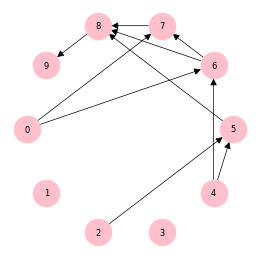


Complete in 0.002 s.
Total independence tests performed: 23
Conditioning set sizes: []
SDC = 1
Direct discrimination detected.
Exposure   = 8
Outcome    = 9
Pred A_CDE = []
True A_CDE = []

Mean time       = 0.003 [0.002,0.003]
Mean tests      = 34.2 [30.7,37.7]
Mean len        = 1.5 [0.77,2.23]
Mean accuracy   = 1.0 [1.0,1.0]
Mean F1         = 1.0 [1.0,1.0]
Mean precision  = 1.0 [1.0,1.0]
Mean recall     = 1.0 [1.0,1.0]


In [19]:
# Evaluate 10x10 matrices.
eval_ld3_oracle(adj_matrices_10n_10m, exposures_10n_10m, outcomes_10n_10m, true_parents_10n_10m)

### 20 nodes

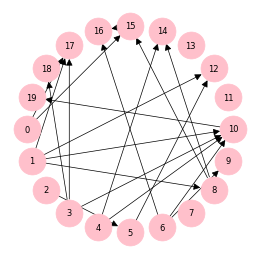


Complete in 0.07 s.
Total independence tests performed: 61
Conditioning set sizes: [8, 8, 8, 8, 3, 3, 3]
SDC = 1
Direct discrimination detected.
Exposure   = 1
Outcome    = 17
Pred A_CDE = ['0', '3']
True A_CDE = ['0', '3']


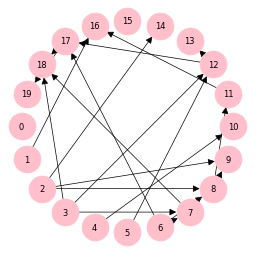


Complete in 0.009 s.
Total independence tests performed: 70
Conditioning set sizes: [12, 12, 12, 12, 12, 8, 8, 8, 8, 8, 8]
SDC = 1
Direct discrimination detected.
Exposure   = 3
Outcome    = 18
Pred A_CDE = ['7', '17']
True A_CDE = ['7', '17']


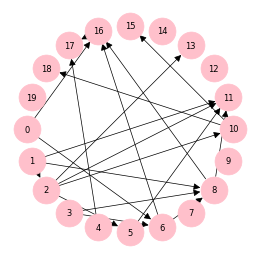


Complete in 0.009 s.
Total independence tests performed: 73
Conditioning set sizes: [13, 13, 13, 13, 13, 13, 13, 13, 13, 6, 6, 6]
SDC = 1
Direct discrimination detected.
Exposure   = 1
Outcome    = 11
Pred A_CDE = ['2', '5', '8']
True A_CDE = ['2', '5', '8']


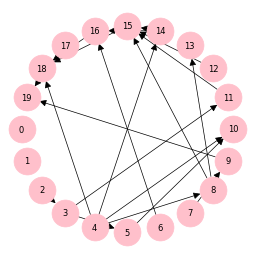


Complete in 0.01 s.
Total independence tests performed: 73
Conditioning set sizes: [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 3]
SDC = 1
Direct discrimination detected.
Exposure   = 15
Outcome    = 18
Pred A_CDE = ['4', '16']
True A_CDE = ['4', '16']


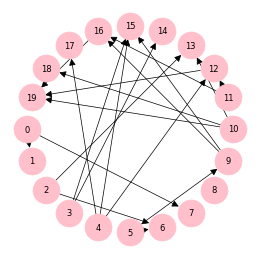


Complete in 0.008 s.
Total independence tests performed: 62
Conditioning set sizes: [8, 8, 8, 8, 8, 8, 8, 8]
SDC = 1
Direct discrimination detected.
Exposure   = 3
Outcome    = 15
Pred A_CDE = ['4', '9']
True A_CDE = ['4', '9']


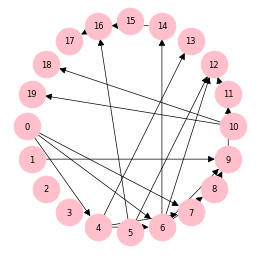


Complete in 0.008 s.
Total independence tests performed: 63
Conditioning set sizes: [7, 7, 4, 4, 4, 4]
SDC = 1
Direct discrimination detected.
Exposure   = 6
Outcome    = 12
Pred A_CDE = ['5', '10']
True A_CDE = ['5', '10']


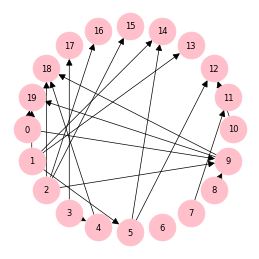


Complete in 0.008 s.
Total independence tests performed: 64
Conditioning set sizes: [10, 10, 10, 10, 10, 10, 4, 4, 4]
SDC = 1
Direct discrimination detected.
Exposure   = 9
Outcome    = 18
Pred A_CDE = ['2', '4']
True A_CDE = ['2', '4']


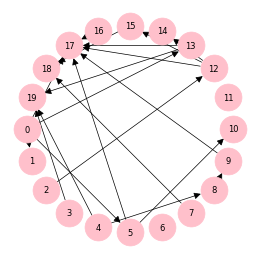


Complete in 0.009 s.
Total independence tests performed: 71
Conditioning set sizes: [10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
SDC = 1
Direct discrimination detected.
Exposure   = 12
Outcome    = 17
Pred A_CDE = ['0', '5', '9', '13', '16']
True A_CDE = ['0', '5', '9', '13', '16']


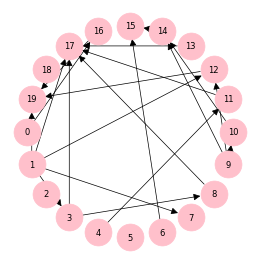


Complete in 0.008 s.
Total independence tests performed: 61
Conditioning set sizes: [9, 9, 9, 9, 9, 5, 5, 5]
SDC = 1
Direct discrimination detected.
Exposure   = 8
Outcome    = 17
Pred A_CDE = ['1', '3', '11', '13']
True A_CDE = ['1', '3', '11', '13']


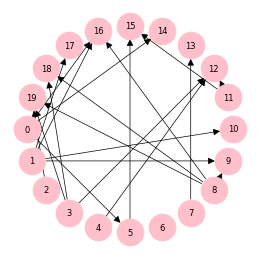


Complete in 0.006 s.
Total independence tests performed: 50
Conditioning set sizes: [4, 4, 4, 4]
SDC = 1
Direct discrimination detected.
Exposure   = 11
Outcome    = 12
Pred A_CDE = ['3', '4']
True A_CDE = ['3', '4']

Mean time       = 0.015 [0.002,0.027]
Mean tests      = 64.8 [60.37,69.23]
Mean len        = 2.6 [1.93,3.27]
Mean accuracy   = 1.0 [1.0,1.0]
Mean F1         = 1.0 [1.0,1.0]
Mean precision  = 1.0 [1.0,1.0]
Mean recall     = 1.0 [1.0,1.0]


In [20]:
# Evaluate 20x20 matrices.
eval_ld3_oracle(adj_matrices_20n_20m[:10], exposures_20n_20m[:10], outcomes_20n_20m[:10], true_parents_20n_20m[:10])

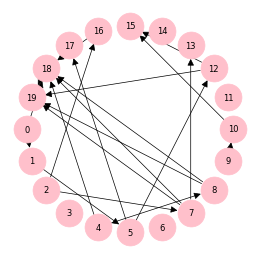


Complete in 0.009 s.
Total independence tests performed: 71
Conditioning set sizes: [12, 12, 12, 12, 12, 7, 7, 7, 7, 7, 7]
SDC = 1
Direct discrimination detected.
Exposure   = 12
Outcome    = 19
Pred A_CDE = ['18', '7', '8']
True A_CDE = ['7', '8', '18']


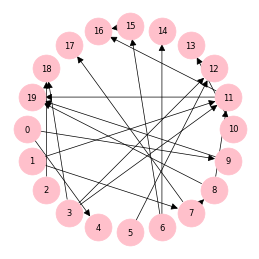


Complete in 0.009 s.
Total independence tests performed: 70
Conditioning set sizes: [12, 12, 12, 12, 12, 7, 7, 7, 7, 7, 7]
SDC = 1
Direct discrimination detected.
Exposure   = 8
Outcome    = 19
Pred A_CDE = ['11', '9']
True A_CDE = ['9', '11']


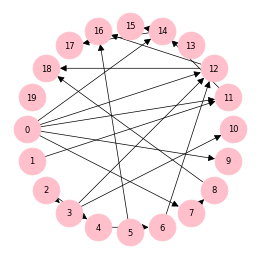


Complete in 0.007 s.
Total independence tests performed: 54
Conditioning set sizes: [1]
SDC = 1
Direct discrimination detected.
Exposure   = 12
Outcome    = 16
Pred A_CDE = ['5']
True A_CDE = ['5']


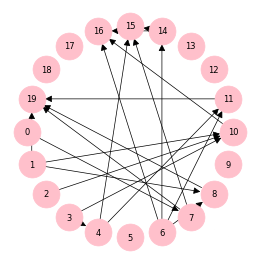


Complete in 0.009 s.
Total independence tests performed: 68
Conditioning set sizes: [11, 9, 9, 9, 9, 9, 9, 9, 9, 9]
SDC = 1
Direct discrimination detected.
Exposure   = 7
Outcome    = 19
Pred A_CDE = ['1', '8', '11']
True A_CDE = ['1', '8', '11']


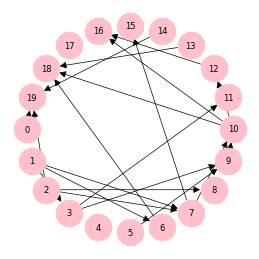


Complete in 0.068 s.
Total independence tests performed: 79
Conditioning set sizes: [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
SDC = 1
Direct discrimination detected.
Exposure   = 13
Outcome    = 18
Pred A_CDE = ['6', '10']
True A_CDE = ['6', '10']


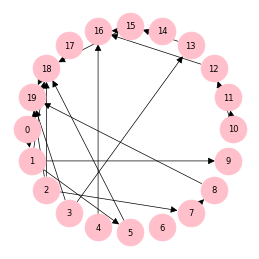


Complete in 0.008 s.
Total independence tests performed: 67
Conditioning set sizes: [11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
SDC = 1
Direct discrimination detected.
Exposure   = 18
Outcome    = 19
Pred A_CDE = ['2', '3', '8']
True A_CDE = ['2', '3', '8']


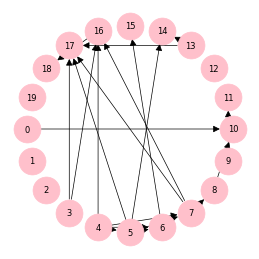


Complete in 0.009 s.
Total independence tests performed: 70
Conditioning set sizes: [12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
SDC = 1
Direct discrimination detected.
Exposure   = 13
Outcome    = 17
Pred A_CDE = ['3', '5', '7']
True A_CDE = ['3', '5', '7']


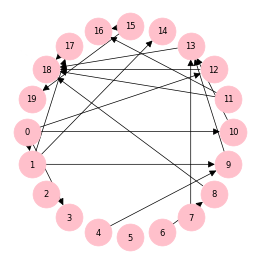


Complete in 0.011 s.
Total independence tests performed: 79
Conditioning set sizes: [15, 15, 15, 15, 15, 15, 15, 15, 8, 8, 8, 8, 8, 8]
SDC = 1
Direct discrimination detected.
Exposure   = 12
Outcome    = 18
Pred A_CDE = ['13', '17', '8', '11']
True A_CDE = ['8', '11', '13', '17']


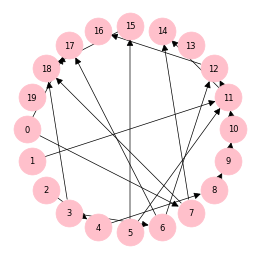


Complete in 0.009 s.
Total independence tests performed: 65
Conditioning set sizes: [10, 10, 10, 6, 6, 6, 6, 6, 6]
SDC = 1
Direct discrimination detected.
Exposure   = 3
Outcome    = 18
Pred A_CDE = ['7', '15']
True A_CDE = ['7', '15']


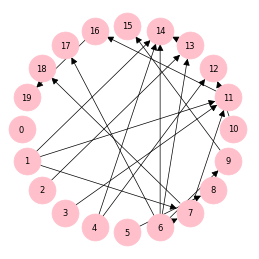


Complete in 0.009 s.
Total independence tests performed: 76
Conditioning set sizes: [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 4, 4, 4]
SDC = 1
Direct discrimination detected.
Exposure   = 13
Outcome    = 14
Pred A_CDE = ['6', '1', '4']
True A_CDE = ['1', '4', '6']

Mean time       = 0.015 [0.003,0.027]
Mean tests      = 69.9 [65.31,74.49]
Mean len        = 2.6 [2.08,3.12]
Mean accuracy   = 1.0 [1.0,1.0]
Mean F1         = 1.0 [1.0,1.0]
Mean precision  = 1.0 [1.0,1.0]
Mean recall     = 1.0 [1.0,1.0]


In [21]:
# Evaluate 20x20 matrices.
eval_ld3_oracle(adj_matrices_20n_20m[10:], exposures_20n_20m[10:], outcomes_20n_20m[10:], true_parents_20n_20m[10:])

### 30 nodes

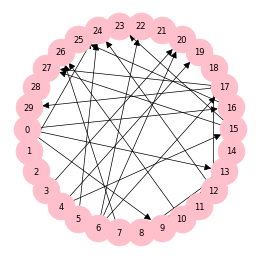


Complete in 0.011 s.
Total independence tests performed: 67
Conditioning set sizes: [2, 2]
SDC = 1
Direct discrimination detected.
Exposure   = 12
Outcome    = 24
Pred A_CDE = ['1', '5']
True A_CDE = ['1', '5']


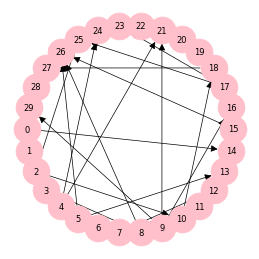


Complete in 0.015 s.
Total independence tests performed: 92
Conditioning set sizes: [9, 7, 7, 7, 7, 7, 7, 7]
SDC = 1
Direct discrimination detected.
Exposure   = 10
Outcome    = 13
Pred A_CDE = ['5', '11']
True A_CDE = ['5', '11']


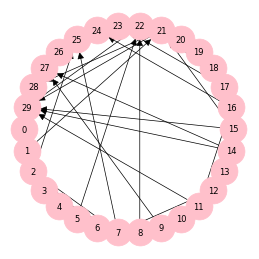


Complete in 0.022 s.
Total independence tests performed: 123
Conditioning set sizes: [23, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22]
SDC = 1
Direct discrimination detected.
Exposure   = 14
Outcome    = 29
Pred A_CDE = ['27', '11', '15', '21', '22', '25']
True A_CDE = ['11', '15', '21', '22', '25', '27']


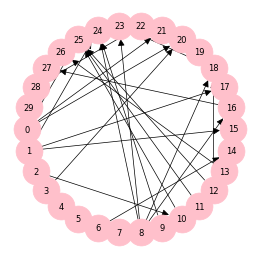


Complete in 0.019 s.
Total independence tests performed: 111
Conditioning set sizes: [18, 18, 18, 18, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
SDC = 1
Direct discrimination detected.
Exposure   = 0
Outcome    = 25
Pred A_CDE = ['24', '10', '11', '12']
True A_CDE = ['10', '11', '12', '24']


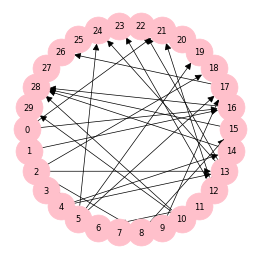


Complete in 0.019 s.
Total independence tests performed: 115
Conditioning set sizes: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
SDC = 1
Direct discrimination detected.
Exposure   = 10
Outcome    = 28
Pred A_CDE = ['14', '15', '16']
True A_CDE = ['14', '15', '16']


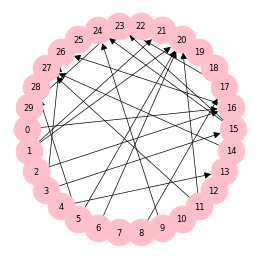


Complete in 0.014 s.
Total independence tests performed: 87
Conditioning set sizes: [11, 11, 11, 8, 8, 8, 8, 8, 8, 8]
SDC = 1
Direct discrimination detected.
Exposure   = 1
Outcome    = 27
Pred A_CDE = ['25', '0', '11', '14']
True A_CDE = ['0', '11', '14', '25']


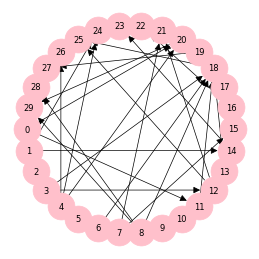


Complete in 0.012 s.
Total independence tests performed: 75
Conditioning set sizes: [4, 4, 4, 4]
SDC = 1
Direct discrimination detected.
Exposure   = 12
Outcome    = 21
Pred A_CDE = ['7', '19']
True A_CDE = ['7', '19']


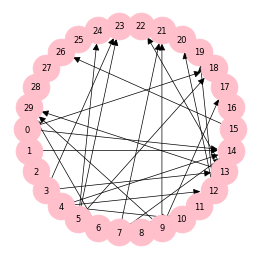


Complete in 0.015 s.
Total independence tests performed: 94
Conditioning set sizes: [13, 13, 13, 13, 13, 13, 13, 6, 6, 6, 6, 6]
SDC = 1
Direct discrimination detected.
Exposure   = 12
Outcome    = 14
Pred A_CDE = ['4', '0', '1', '7']
True A_CDE = ['0', '1', '4', '7']


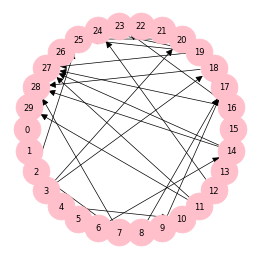


Complete in 0.072 s.
Total independence tests performed: 99
Conditioning set sizes: [15, 15, 15, 15, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10]
SDC = 1
Direct discrimination detected.
Exposure   = 24
Outcome    = 27
Pred A_CDE = ['19', '11', '14', '16']
True A_CDE = ['11', '14', '16', '19']


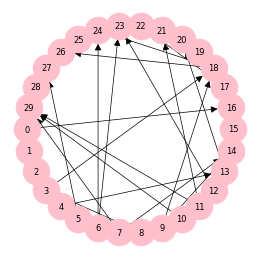


Complete in 0.012 s.
Total independence tests performed: 73
Conditioning set sizes: [3, 3, 3]
SDC = 1
Direct discrimination detected.
Exposure   = 7
Outcome    = 29
Pred A_CDE = ['10', '11']
True A_CDE = ['10', '11']

Mean time       = 0.021 [0.01,0.032]
Mean tests      = 93.6 [81.95,105.25]
Mean len        = 3.3 [2.47,4.13]
Mean accuracy   = 1.0 [1.0,1.0]
Mean F1         = 1.0 [1.0,1.0]
Mean precision  = 1.0 [1.0,1.0]
Mean recall     = 1.0 [1.0,1.0]


In [22]:
# Evaluate 30x30 matrices.
eval_ld3_oracle(adj_matrices_30n_30m, exposures_30n_30m, outcomes_30n_30m, true_parents_30n_30m)

### 40 nodes

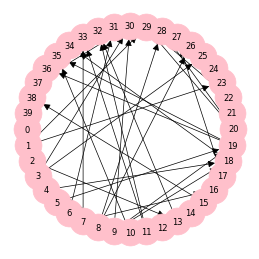


Complete in 0.026 s.
Total independence tests performed: 120
Conditioning set sizes: [14, 14, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
SDC = 1
Direct discrimination detected.
Exposure   = 7
Outcome    = 33
Pred A_CDE = ['11', '28', '32']
True A_CDE = ['11', '28', '32']


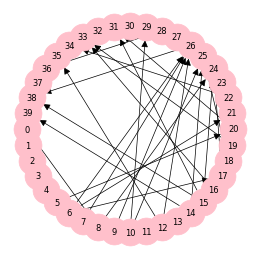


Complete in 0.029 s.
Total independence tests performed: 137
Conditioning set sizes: [21, 21, 21, 21, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
SDC = 1
Direct discrimination detected.
Exposure   = 15
Outcome    = 38
Pred A_CDE = ['2', '26', '34']
True A_CDE = ['2', '26', '34']


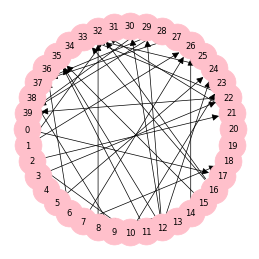


Complete in 0.024 s.
Total independence tests performed: 114
Conditioning set sizes: [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]
SDC = 1
Direct discrimination detected.
Exposure   = 16
Outcome    = 33
Pred A_CDE = ['22', '24', '28']
True A_CDE = ['22', '24', '28']


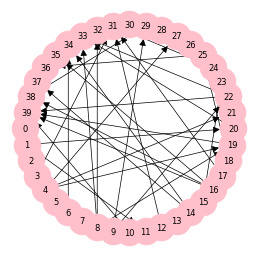


Complete in 0.026 s.
Total independence tests performed: 125
Conditioning set sizes: [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
SDC = 1
Direct discrimination detected.
Exposure   = 10
Outcome    = 39
Pred A_CDE = ['3', '16', '19', '22']
True A_CDE = ['3', '16', '19', '22']


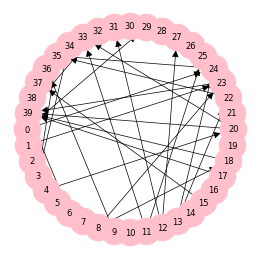


Complete in 0.026 s.
Total independence tests performed: 122
Conditioning set sizes: [15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
SDC = 1
Direct discrimination detected.
Exposure   = 32
Outcome    = 39
Pred A_CDE = ['6', '17', '18', '20', '23']
True A_CDE = ['6', '17', '18', '20', '23']


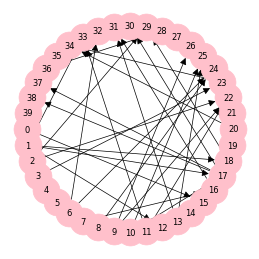


Complete in 0.02 s.
Total independence tests performed: 99
Conditioning set sizes: [6, 4, 4, 4, 4]
SDC = 1
Direct discrimination detected.
Exposure   = 11
Outcome    = 22
Pred A_CDE = ['2', '9']
True A_CDE = ['2', '9']


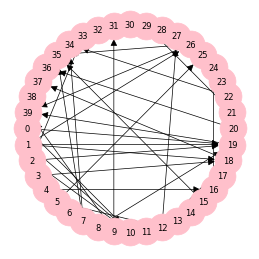


Complete in 0.023 s.
Total independence tests performed: 111
Conditioning set sizes: [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]
SDC = 1
Direct discrimination detected.
Exposure   = 7
Outcome    = 35
Pred A_CDE = ['15', '26', '31']
True A_CDE = ['15', '26', '31']


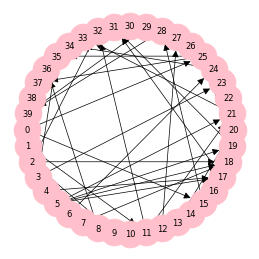


Complete in 0.088 s.
Total independence tests performed: 147
Conditioning set sizes: [23, 23, 23, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
SDC = 1
Direct discrimination detected.
Exposure   = 32
Outcome    = 36
Pred A_CDE = ['8', '31', '34']
True A_CDE = ['8', '31', '34']


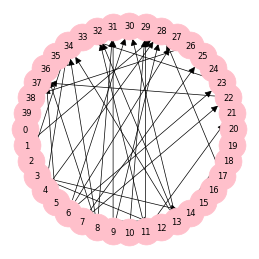


Complete in 0.024 s.
Total independence tests performed: 119
Conditioning set sizes: [14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
SDC = 1
Direct discrimination detected.
Exposure   = 17
Outcome    = 28
Pred A_CDE = ['1', '4', '9', '23']
True A_CDE = ['1', '4', '9', '23']


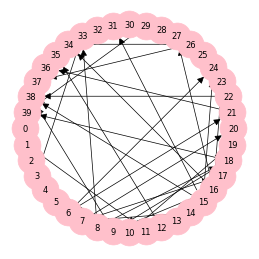


Complete in 0.028 s.
Total independence tests performed: 135
Conditioning set sizes: [20, 20, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]
SDC = 1
Direct discrimination detected.
Exposure   = 22
Outcome    = 38
Pred A_CDE = ['9', '15']
True A_CDE = ['9', '15']

Mean time       = 0.031 [0.019,0.044]
Mean tests      = 122.9 [114.26,131.54]
Mean len        = 3.2 [2.63,3.77]
Mean accuracy   = 1.0 [1.0,1.0]
Mean F1         = 1.0 [1.0,1.0]
Mean precision  = 1.0 [1.0,1.0]
Mean recall     = 1.0 [1.0,1.0]


In [23]:
# Evaluate 40x40 matrices.
eval_ld3_oracle(adj_matrices_40n_40m, exposures_40n_40m, outcomes_40n_40m, true_parents_40n_40m)

### 50 nodes

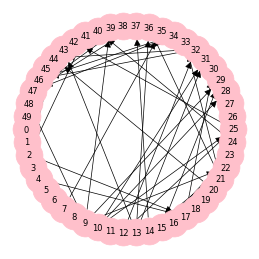


Complete in 0.037 s.
Total independence tests performed: 150
Conditioning set sizes: [18, 18, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
SDC = 1
Direct discrimination detected.
Exposure   = 40
Outcome    = 44
Pred A_CDE = ['2', '20', '32']
True A_CDE = ['2', '20', '32']


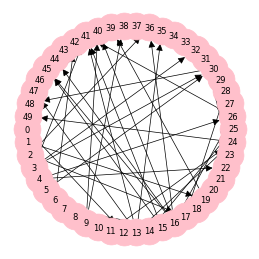


Complete in 0.044 s.
Total independence tests performed: 176
Conditioning set sizes: [27, 27, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
SDC = 1
Direct discrimination detected.
Exposure   = 15
Outcome    = 41
Pred A_CDE = ['3', '13', '26']
True A_CDE = ['3', '13', '26']


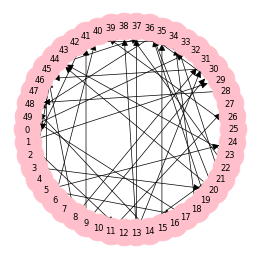


Complete in 0.028 s.
Total independence tests performed: 114
Conditioning set sizes: [6, 6, 5, 5, 5]
SDC = 1
Direct discrimination detected.
Exposure   = 3
Outcome    = 44
Pred A_CDE = ['20', '36', '23']
True A_CDE = ['20', '23', '36']


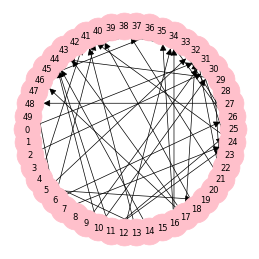


Complete in 0.039 s.
Total independence tests performed: 157
Conditioning set sizes: [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]
SDC = 1
Direct discrimination detected.
Exposure   = 39
Outcome    = 44
Pred A_CDE = ['10', '11', '14', '29', '36']
True A_CDE = ['10', '11', '14', '29', '36']


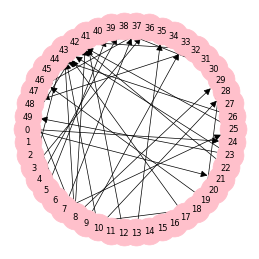


Complete in 0.043 s.
Total independence tests performed: 175
Conditioning set sizes: [26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26]
SDC = 1
Direct discrimination detected.
Exposure   = 17
Outcome    = 43
Pred A_CDE = ['3', '8', '10', '23', '42']
True A_CDE = ['3', '8', '10', '23', '42']


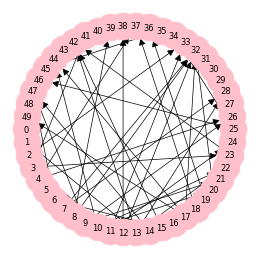


Complete in 0.037 s.
Total independence tests performed: 152
Conditioning set sizes: [19, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
SDC = 1
Direct discrimination detected.
Exposure   = 9
Outcome    = 26
Pred A_CDE = ['21', '4']
True A_CDE = ['4', '21']


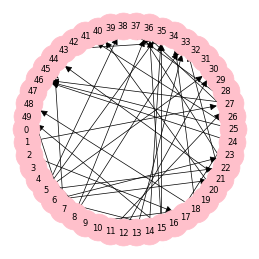


Complete in 0.041 s.
Total independence tests performed: 166
Conditioning set sizes: [24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 3, 3]
SDC = 1
Direct discrimination detected.
Exposure   = 35
Outcome    = 40
Pred A_CDE = ['37', '20']
True A_CDE = ['20', '37']


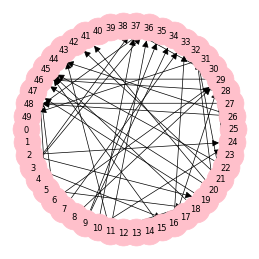


Complete in 0.036 s.
Total independence tests performed: 145
Conditioning set sizes: [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
SDC = 1
Direct discrimination detected.
Exposure   = 28
Outcome    = 46
Pred A_CDE = ['5', '6', '20', '29']
True A_CDE = ['5', '6', '20', '29']


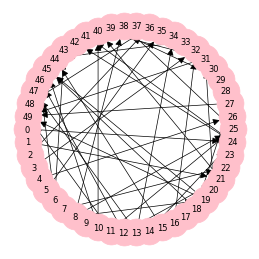


Complete in 0.034 s.
Total independence tests performed: 139
Conditioning set sizes: [15, 15, 15, 15, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
SDC = 1
Direct discrimination detected.
Exposure   = 11
Outcome    = 49
Pred A_CDE = ['19', '27', '31']
True A_CDE = ['19', '27', '31']


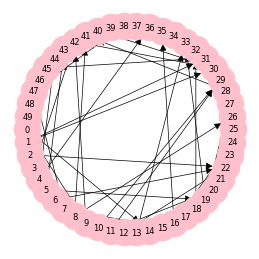


Complete in 0.025 s.
Total independence tests performed: 103
Conditioning set sizes: [2, 2]
SDC = 1
Direct discrimination detected.
Exposure   = 2
Outcome    = 22
Pred A_CDE = ['6', '12']
True A_CDE = ['6', '12']

Mean time       = 0.036 [0.033,0.04]
Mean tests      = 147.7 [132.79,162.61]
Mean len        = 3.2 [2.5,3.9]
Mean accuracy   = 1.0 [1.0,1.0]
Mean F1         = 1.0 [1.0,1.0]
Mean precision  = 1.0 [1.0,1.0]
Mean recall     = 1.0 [1.0,1.0]


In [24]:
# Evaluate 50x50 matrices.
eval_ld3_oracle(adj_matrices_50n_50m, exposures_50n_50m, outcomes_50n_50m, true_parents_50n_50m)

### 100 nodes

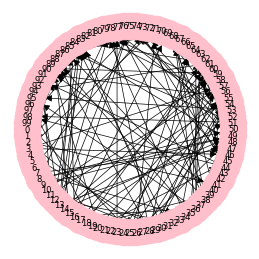


Complete in 0.159 s.
Total independence tests performed: 294
Conditioning set sizes: [25, 25, 25, 25, 25, 25, 25, 25, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
SDC = 1
Direct discrimination detected.
Exposure   = 48
Outcome    = 57
Pred A_CDE = ['3', '11', '20', '45']
True A_CDE = ['3', '11', '20', '45']


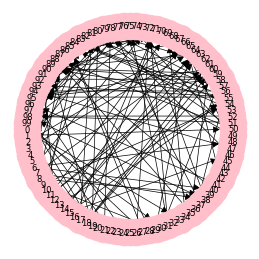


Complete in 0.221 s.
Total independence tests performed: 399
Conditioning set sizes: [68, 68, 68, 68, 68, 68, 68, 68, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60]
SDC = 1
Direct discrimination detected.
Exposure   = 19
Outcome    = 98
Pred A_CDE = ['81', '22', '38', '51', '52', '75']
True A_CDE = ['22', '38', '51', '52', '75', '81']


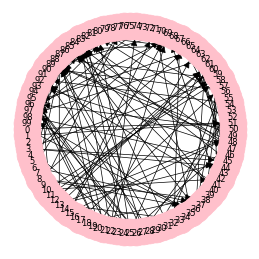


Complete in 0.208 s.
Total independence tests performed: 377
Conditioning set sizes: [60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33]
SDC = 1
Direct discrimination detected.
Exposure   = 25
Outcome    = 95
Pred A_CDE = ['3', '26', '88', '20', '22']
True A_CDE = ['3', '20', '22', '26', '88']


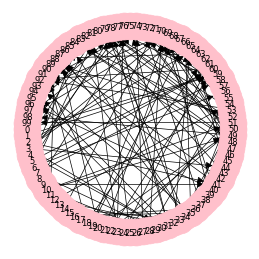


Complete in 0.192 s.
Total independence tests performed: 346
Conditioning set sizes: [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]
SDC = 1
Direct discrimination detected.
Exposure   = 6
Outcome    = 80
Pred A_CDE = ['2', '43', '50', '66']
True A_CDE = ['2', '43', '50', '66']


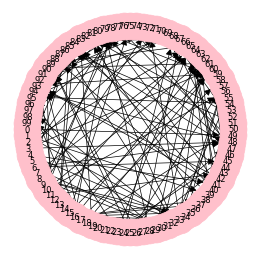


Complete in 0.181 s.
Total independence tests performed: 337
Conditioning set sizes: [47, 47, 47, 47, 47, 47, 47, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]
SDC = 1
Direct discrimination detected.
Exposure   = 86
Outcome    = 95
Pred A_CDE = ['3', '6', '23', '54', '68']
True A_CDE = ['3', '6', '23', '54', '68']


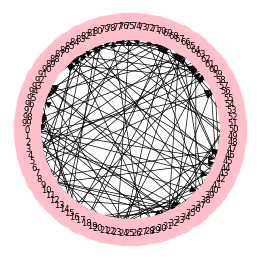


Complete in 0.217 s.
Total independence tests performed: 392
Conditioning set sizes: [66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38]
SDC = 1
Direct discrimination detected.
Exposure   = 35
Outcome    = 92
Pred A_CDE = ['25', '36', '43', '89']
True A_CDE = ['25', '36', '43', '89']


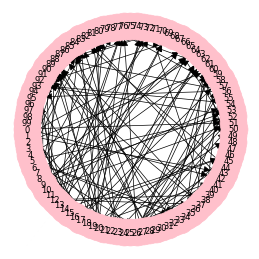


Complete in 0.208 s.
Total independence tests performed: 382
Conditioning set sizes: [62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18]
SDC = 1
Direct discrimination detected.
Exposure   = 28
Outcome    = 89
Pred A_CDE = ['21', '83', '33', '70', '75']
True A_CDE = ['21', '33', '70', '75', '83']


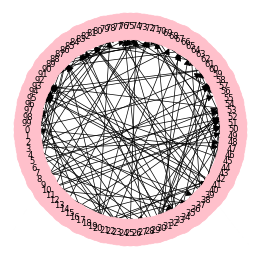


Complete in 0.215 s.
Total independence tests performed: 385
Conditioning set sizes: [63, 63, 63, 63, 63, 63, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56]
SDC = 1
Direct discrimination detected.
Exposure   = 40
Outcome    = 94
Pred A_CDE = ['18', '41', '45', '60', '75', '89']
True A_CDE = ['18', '41', '45', '60', '75', '89']


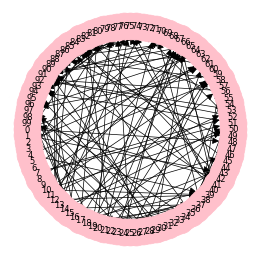


Complete in 0.239 s.
Total independence tests performed: 423
Conditioning set sizes: [76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46]
SDC = 1
Direct discrimination detected.
Exposure   = 16
Outcome    = 90
Pred A_CDE = ['72', '83', '29', '41', '74']
True A_CDE = ['29', '41', '72', '74', '83']


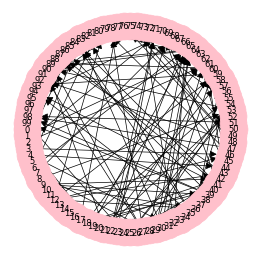


Complete in 0.23 s.
Total independence tests performed: 413
Conditioning set sizes: [73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31]
SDC = 1
Direct discrimination detected.
Exposure   = 87
Outcome    = 99
Pred A_CDE = ['14', '95', '5', '24', '39', '85', '97']
True A_CDE = ['5', '14', '24', '39', '85', '95', '97']

Mean time       = 0.207 [0.192,0.222]
Mean tests      = 374.8 [350.7,398.9]
Mean len        = 5.1 [4.48,5.72]
Mean accuracy   = 1.0 [1.0,1.0]
Mean F1         = 1.0 [1.0,1.0]
Mean precision  = 1.0 [1.0,1.0]
Mean recall     = 1.0 [1.0,1.0]


In [25]:
# Evaluate 100x100 matrices.
eval_ld3_oracle(adj_matrices_100n_150m, exposures_100n_150m, outcomes_100n_150m, true_parents_100n_150m)

### 200 nodes

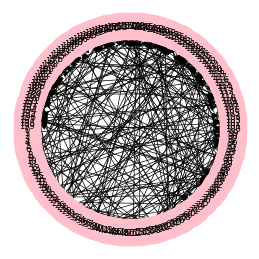


Complete in 0.565 s.
Total independence tests performed: 542
Conditioning set sizes: [49, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47]
SDC = 1
Direct discrimination detected.
Exposure   = 144
Outcome    = 196
Pred A_CDE = ['31', '83', '84', '86', '184']
True A_CDE = ['31', '83', '84', '86', '184']


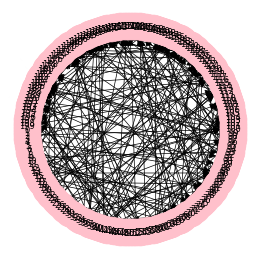


Complete in 0.789 s.
Total independence tests performed: 724
Conditioning set sizes: [110, 110, 110, 110, 110, 110, 110, 110, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101]
SDC = 1
Direct discrimination detected.
Exposure   = 49
Outcome    = 186
Pred A_CDE = ['11', '86', '97', '118']
True A_CDE = ['11', '86', '97', '118']


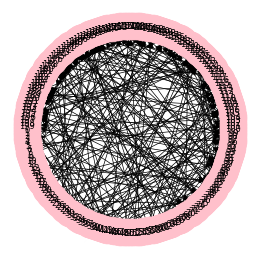


Complete in 0.822 s.
Total independence tests performed: 709
Conditioning set sizes: [104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 104, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78]
SDC = 1
Direct discrimination detected.
Exposure   = 41
Outcome    = 196
Pred A_CDE = ['122', '91', '121', '124', '155']
True A_CDE = ['91', '121', '122', '124', '155']


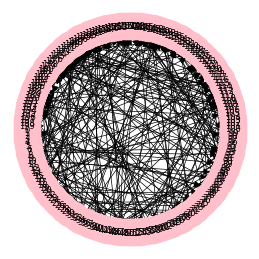


Complete in 0.755 s.
Total independence tests performed: 725
Conditioning set sizes: [109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92]
SDC = 1
Direct discrimination detected.
Exposure   = 16
Outcome    = 148
Pred A_CDE = ['27', '59', '66', '91', '92', '113', '125', '143', '147']
True A_CDE = ['27', '59', '66', '91', '92', '113', '125', '143', '147']


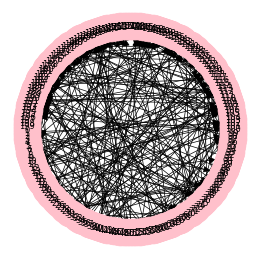


Complete in 0.692 s.
Total independence tests performed: 668
Conditioning set sizes: [90, 90, 90, 90, 90, 90, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83]
SDC = 1
Direct discrimination detected.
Exposure   = 22
Outcome    = 183
Pred A_CDE = ['45', '64', '78', '81', '97', '180']
True A_CDE = ['45', '64', '78', '81', '97', '180']


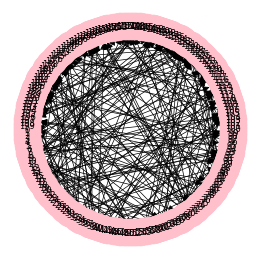


Complete in 0.9 s.
Total independence tests performed: 784
Conditioning set sizes: [130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 130, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47]
SDC = 1
Direct discrimination detected.
Exposure   = 172
Outcome    = 199
Pred A_CDE = ['181', '0', '59', '78', '160', '177']
True A_CDE = ['0', '59', '78', '160', '177', '181']


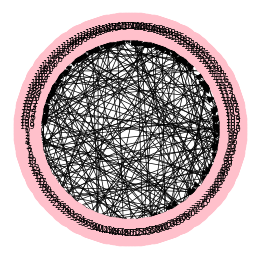


Complete in 0.833 s.
Total independence tests performed: 745
Conditioning set sizes: [117, 117, 117, 117, 117, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111, 111]
SDC = 1
Direct discrimination detected.
Exposure   = 20
Outcome    = 199
Pred A_CDE = ['35', '155', '169', '194', '196']
True A_CDE = ['35', '155', '169', '194', '196']


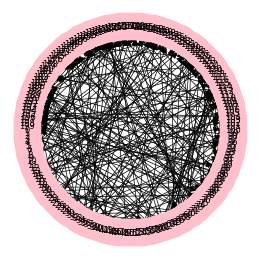


Complete in 0.724 s.
Total independence tests performed: 642
Conditioning set sizes: [77, 77, 77, 77, 77, 77, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70]
SDC = 1
Direct discrimination detected.
Exposure   = 18
Outcome    = 187
Pred A_CDE = ['20', '28', '55', '75', '96', '133']
True A_CDE = ['20', '28', '55', '75', '96', '133']


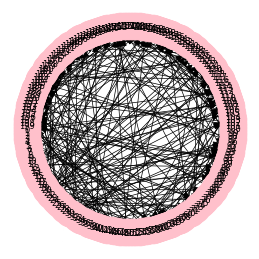


Complete in 0.713 s.
Total independence tests performed: 644
Conditioning set sizes: [77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48]
SDC = 1
Direct discrimination detected.
Exposure   = 19
Outcome    = 186
Pred A_CDE = ['35', '57', '80', '123', '155']
True A_CDE = ['35', '57', '80', '123', '155']


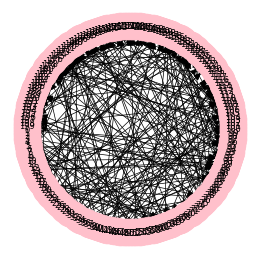


Complete in 0.915 s.
Total independence tests performed: 811
Conditioning set sizes: [139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 139, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37]
SDC = 1
Direct discrimination detected.
Exposure   = 144
Outcome    = 181
Pred A_CDE = ['138', '18', '33', '51', '75']
True A_CDE = ['18', '33', '51', '75', '138']

Mean time       = 0.771 [0.706,0.836]
Mean tests      = 699.4 [650.87,747.93]
Mean len        

In [35]:
# Evaluate 200x200 matrices.
eval_ld3_oracle(adj_matrices_200n_300m, exposures_200n_300m, outcomes_200n_300m, true_parents_200n_300m)

### 500 nodes

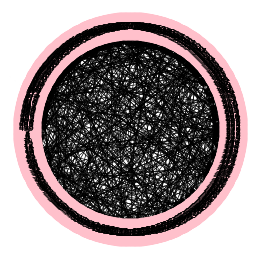


Complete in 5.128 s.
Total independence tests performed: 1597
Conditioning set sizes: [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 103, 10

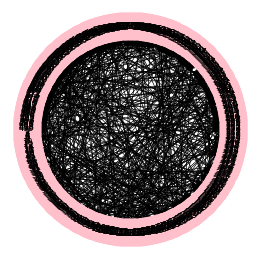


Complete in 4.871 s.
Total independence tests performed: 1537
Conditioning set sizes: [181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 181, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136, 136]
SDC = 1
Dire

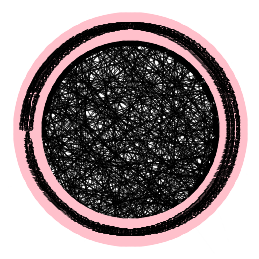


Complete in 3.651 s.
Total independence tests performed: 1187
Conditioning set sizes: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63]
SDC = 1
Direct discrimination detected.
Exposure   = 72
Outcome    = 335
Pred A_CDE = ['67', '131', '175', '204', '296']
True A_CDE = ['67', '131', '175', '204', '296']


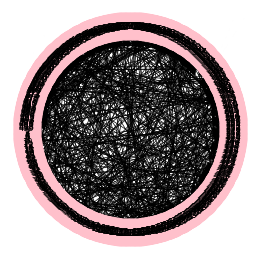


Complete in 4.382 s.
Total independence tests performed: 1373
Conditioning set sizes: [126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 126, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77]
SDC = 1
Direct discrimination detected.
Exposure   = 265
Outcome    = 447
Pred A_CDE = ['345', '7', '71', '138', '240', '352', '366', '434']
True A_CDE = ['7', '71', '138', '240', '345', '352', '366', '434']


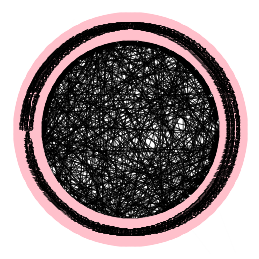


Complete in 5.621 s.
Total independence tests performed: 1743
Conditioning set sizes: [248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 248, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 236, 23

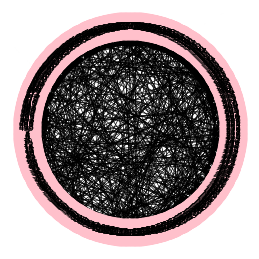


Complete in 4.724 s.
Total independence tests performed: 1481
Conditioning set sizes: [161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161]
SDC = 1
Direct discrimination detected.
Exposure   = 228
Outcome    = 486
Pred A_CDE = ['41', '248', '343',

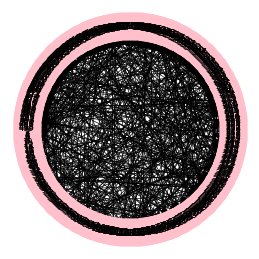


Complete in 3.745 s.
Total independence tests performed: 1202
Conditioning set sizes: [62, 62, 62, 62, 62, 62, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55]
SDC = 1
Direct discrimination detected.
Exposure   = 76
Outcome    = 293
Pred A_CDE = ['48', '148', '219', '229', '239']
True A_CDE = ['48', '148', '219', '229', '239']


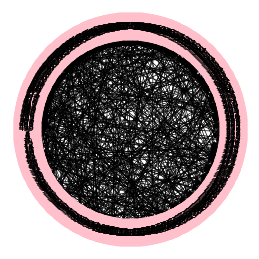


Complete in 5.005 s.
Total independence tests performed: 1521
Conditioning set sizes: [174, 174, 174, 174, 174, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168, 168]
SDC = 1
Direct discrimination detected.
Exposur

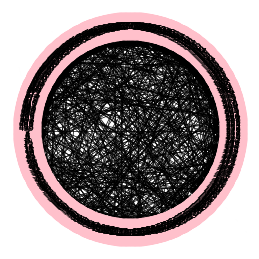


Complete in 4.965 s.
Total independence tests performed: 1498
Conditioning set sizes: [168, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166, 166]
SDC = 1
Direct discrimination detected.
Exposure   = 243
Outcome    = 420
Pre

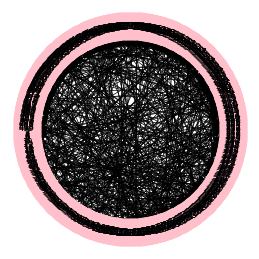


Complete in 4.377 s.
Total independence tests performed: 1365
Conditioning set sizes: [123, 123, 123, 123, 123, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117]
SDC = 1
Direct discrimination detected.
Exposure   = 191
Outcome    = 459
Pred A_CDE = ['145', '342', '370', '375', '408']
True A_CDE = ['145', '342', '370', '375', '408']

Mean time       = 4.647 [4.265,5.029]
Mean tests      = 1450.4 [1343.61,1557.19]
Mean len        = 6.3 [5.58,7.02]
Mean accuracy 

In [39]:
eval_ld3_oracle(adj_matrices_500n_700m, exposures_500n_700m, outcomes_500n_700m, true_parents_500n_700m)

## End of document